# Part III (Convexity Correction)
We start by importing the following modules needed for our computation:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brentq, least_squares
from scipy.stats import norm
from scipy.integrate import quad
from math import log, exp, sqrt
from scipy import interpolate
from scipy.interpolate import CubicSpline

We need the following data from the earlier parts, in particular Part 1 and Part 2:

In [2]:
transformed_data = pd.read_csv("discount_factors.csv")
transformed_data

,Tenor,OIS product,OIS rate,OIS overnight rate,OIS discount factor,IRS product,IRS rate,LIBOR forward rate,LIBOR discount factor
0,0.5,OIS,0.00250,0.002497,0.998753,LIBOR,0.0250,0.025000,0.987654
1,1.0,OIS,0.00300,0.002996,0.997013,IRS,0.0280,0.031005,0.972577
2,2.0,OIS,0.00325,0.003245,0.993552,IRS,0.0300,0.032263,0.942179
3,3.0,OIS,0.00335,0.003344,0.990066,IRS,0.0315,0.034814,0.910482
4,4.0,OIS,0.00350,0.003494,0.986217,IRS,0.0325,0.035838,0.878981
5,5.0,OIS,0.00360,0.003594,0.982349,IRS,0.0330,0.035326,0.848990
6,7.0,OIS,0.00400,0.003992,0.972815,IRS,0.0350,0.041296,0.784219
7,10.0,OIS,0.00450,0.004490,0.957030,IRS,0.0370,0.044029,0.692720
8,15.0,OIS,0.00500,0.004988,0.930394,IRS,0.0400,0.051385,0.551123
9,20.0,OIS,0.00525,0.005236,0.905202,IRS,0.0450,0.069915,0.408368


In [3]:
params_df = pd.read_csv("calibrated_params.csv")
params_df

,Unnamed: 0,Expiry,Tenor,Alpha,Nu,Rho,Sigma,Beta
0,0,10Y,10Y,0.164772,0.600363,-0.420789,0.2437,4.459102e-03
1,1,10Y,1Y,0.176061,1.000675,-0.540240,0.2854,3.216240e-07
2,2,10Y,2Y,0.191402,0.914422,-0.532954,0.2928,1.000058e-07
3,3,10Y,3Y,0.200019,0.853172,-0.531122,0.2940,1.992773e-06
4,4,10Y,5Y,0.181849,0.704893,-0.490882,0.2674,2.447620e-05
5,5,1Y,10Y,0.171083,0.777804,-0.264656,0.2447,2.586166e-07
6,6,1Y,1Y,0.139067,2.049536,-0.633241,0.2250,4.831147e-07
7,7,1Y,2Y,0.184652,1.677369,-0.525115,0.2872,3.578737e-08
8,8,1Y,3Y,0.196852,1.438123,-0.482846,0.2978,1.910510e-07
9,9,1Y,5Y,0.178052,1.064876,-0.414420,0.2607,6.681484e-07


In [4]:
alpha_df = pd.DataFrame(data = params_df['Alpha'].values.reshape(3,5), index = [1,5,10], columns = [1,2,3,5,10])
rho_df = pd.DataFrame(data = params_df['Rho'].values.reshape(3,5), index = [1,5,10], columns = [1,2,3,5,10])
nu_df = pd.DataFrame(data = params_df['Nu'].values.reshape(3,5), index = [1,5,10], columns = [1,2,3,5,10])

fsr = pd.read_csv("par_swap_rate.csv")
fsr.set_index('Unnamed: 0', inplace=True)
fsr = fsr.T.unstack().reset_index(name='forward_swap_rate')
fsr.columns = ["Expiry", "Tenor", "forward_swap_rate"]

# Linear interpolation on the OIS dataframe based on time
def OISDF(T, df = transformed_data.copy()):
    x = list(df['Tenor'])
    y = list(df['OIS discount factor'])
    return np.interp(T, x, y)

# Linear interpolation on the LIBOR dataframe based on time
def LIBORDF(T, df = transformed_data.copy()):
    x = list(df['Tenor'])
    y = list(df['LIBOR discount factor'])
    return np.interp(T, x, y)

# using cubic spline to interpolate SABR parameters
def ParameterInterp(T, N, data):
    splied_from_expiry = []
    exp = [int(i) for i in data.index.tolist()]
    for i in data.columns:
        result = CubicSpline(exp, data[i], bc_type=((2, 0.0), (2, 0.0)), extrapolate=True)
        splied_from_expiry.append(result)

    extract = []
    for i in range(len(splied_from_expiry)):
        extract.append(splied_from_expiry[i](T))

    result = CubicSpline([1,2,3,5,10], extract, bc_type=((2, 0.0), (2, 0.0)), extrapolate=True)
    return float(result(N))

Let $m$ denote the payment frequency ($m = 2$ for semi-annual payment frequency), and $N = T_i − T_{i-1}$ denote the tenor of the swap (number of years). Then,
$$
\text{Forward LIBOR} = L(T_{i-1} , T_{i}) = \frac{1}{𝑁} \times \frac{D_0(0, T_{i-1}) - D_0(0, T_i)}{D_0(0, T_i)}
$$

In [5]:
def forward_LIBOR(D1, D2, m):
    f = m * ((D1 - D2) / D2)
    return f

$$
\text{Forward swap rate} = \frac {\text{Floating leg}}{\text{Fixed leg}} = \frac{\sum\limits_{n=i}^{N} D_0(0, T_i) \times L(T_i, T_{i-1}) \times m}{\sum\limits_{n=i}^{N} D_0(0,T_i) \times m}
$$

In [6]:
def forward_swap_rate(exp, N, m):  
    d = 1/m
    month = int(N/d) # number of payments during a tenor period
    flt, fixed = 0, 0 

    for i in range(1, month + 1):
        ti = exp + i * d
        # Floating leg = OIS discount factor x forward LIBOR x delta
        flt += OISDF(ti) * forward_LIBOR(LIBORDF(ti - d), LIBORDF(ti), m) * d

    for i in range(1,month+1):
        # Fixed leg = sum of OIS discount factor from expiry to tenor's end
        fixed += OISDF(exp + i * d) * d

    return flt/fixed

## Questions
1. Using the SABR model calibrated in the previous question, value the following constant maturity swap (CMS) products:
    - PV of a leg receiving CMS10y semi-annually over the next 5 years
    - PV of a leg receiving CMS2y quarterly over the next 10 years

<u>Background</u><br>
A CMS leg is a collection of CMS rates paid over a period. For example, the PV of a leg receiving CMS 10$y$ semi-annually over the next 2 years is
\begin{align}
PV&=D(0,6m)\cdot0.5\cdot\mathbb{E}^T[S_{6m,10y\,6m}(6m)]+D(0,1y)\cdot0.5\cdot\mathbb{E}^T[S_{1y,11y}(1y)]\\&+D(0,1y\,6m)\cdot0.5\cdot\mathbb{E}^T[S_{1y\,6m,11y\,6m}(1y\,6m)]+D(0,2y)\cdot0.5\cdot\mathbb{E}^T[S_{2y,12y}(2y)]
\end{align}
In words, the PV is the sum of the discounted values of the CMS rates, multiplied by the day count fraction. Each CMS rate is calculated using the static-replication approach, i.e., a CMS contract paying the swap rate $S_{n,N}(T)$ at time $T=T_n$ can be expressed as:
$$
\frac{V_0}{D(0,T)}=\mathbb{E}^T\left[\frac{V_T}{D(T,T)}\right]\Rightarrow V_0=D(0,T)\mathbb{E}^T[S_{n,N}(T)]
$$
By the static-replication approach, and choosing the forward swap rate $F=S_{n,N}(0)$ as our expansion point, we can express this as
\begin{align}
V_0&=D(0,T)g(F)+h'(F)[V^{pay}(F)-V^{rec}(F)]+\int_0^Fh''(K)V^{rec}(K)\,dK+\int_F^\infty h''(K)V^{pay}(K)\,dK\\&=D(0,T)g(F)+\int_0^Fh''(K)V^{rec}(K)\,dK+\int_F^\infty h''(K)V^{pay}(K)\,dK
\end{align}
In other words, we can write
$$
\underbrace{\mathbb{E}^T[S_{n,N}(T)]}_{\text{CMS rate}}=g(F)+\frac{1}{D(0,T)}\left[\int_0^Fh''(K)V^{rec}(K)\,dK+\int_F^\infty h''(K)V^{pay}(K)\,dK\right]
$$
Here, the IRR-settled option pricer ($V^{pay}$ or $V^{rec}$) is given by
$$
V(K)=D(0,T)\cdot\text{IRR}(S_{n,N}(0))\cdot\text{Black}(S_{n,N}(0),K,\sigma_{\text{SABR}},T)
$$
so the discount factor $D(0,T)$ can be cancelled away. Since the payoff function is simply $g(K)=K$, we have
$$
h''(K)=\frac{-\text{IRR}''(K)\cdot K-2\cdot\text{IRR}'(K)}{\text{IRR}(K)^2}+\frac{2\cdot\text{IRR}'(K)^2\cdot K}{\text{IRR}(K)^3}
$$

In [7]:
def Black76Call(F, K, sigma, T):
    d1 = (np.log(F/K) + (sigma**2) * T/2)/(sigma * np.sqrt(T))
    d2 = (np.log(F/K) - (sigma**2) * T/2)/(sigma * np.sqrt(T))
    return (F * norm.cdf(d1) - K * norm.cdf(d2))

def Black76Put(F, K, sigma, T):
    d1 = (np.log(F/K) + (sigma ** 2) * T/2)/(sigma * np.sqrt(T))
    d2 = (np.log(F/K) - (sigma ** 2) * T/2)/(sigma * np.sqrt(T))
    return (K * norm.cdf(-d2) - F * norm.cdf(-d1))
    
def SABR(F, K, T, alpha, beta, rho, nu):
    X = K
    if F == K:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom
    return sabrsigma

def IRR_0(K, m, N):
    value = 1/K * (1 - 1/(1 + K/m)**(N * m))
    return value

def IRR_1(K, m, N):
    firstDerivative = -1/K * IRR_0(K, m, N) + 1/(K * m) * N * m/(1 + K/m)**(N * m + 1)
    return firstDerivative

def IRR_2(K, m, N):
    secondDerivative = -2/K * IRR_1(K, m, N) - 1/(K * m**2)*(N * m)*(N * m + 1)/(1 + K/m)**(N * m + 2)
    return secondDerivative

def g_0(K): return K

def g_1(K): return 1

def g_2(K): return 0

def h_0(K, m, N):
    value = g_0(K) / IRR_0(K, m, N)
    return value

def h_1(K, m, N):
    firstDerivative = (IRR_0(K, m, N) * g_1(K) - g_0(K) * IRR_1(K, m, N)) / IRR_0(K, m, N)**2
    return firstDerivative

def h_2(K, m, N):
    secondDerivative = ((IRR_0(K, m, N) * g_2(K) - IRR_2(K, m, N) * g_0(K) - 2 * IRR_1(K, m, N) * g_1(K))/IRR_0(K, m, N)**2 
                        + 2.0 * IRR_1(K, m, N)**2 * g_0(K)/IRR_0(K, m, N)**3)
    return secondDerivative

def payer_integrand(S_n_N, K, sigma, T, m, N):
    price = h_2(K, m, N) * Black76Call(S_n_N, K, sigma, T)
    return price

def receiver_integrand(S_n_N, K, sigma, T, m, N):
    price = h_2(K, m, N) * Black76Put(S_n_N, K, sigma, T)
    return price

def CMS(T, N, m):
    F = forward_swap_rate(T, N, m)
    alpha = ParameterInterp(T, N, alpha_df)
    rho = ParameterInterp(T, N, rho_df)
    nu = ParameterInterp(T, N, nu_df)
    
    VRec = quad(lambda x: receiver_integrand(F, x, SABR(F, x, T, alpha, 0.9, rho, nu), T, m, N), 0, F)
    VPay = quad(lambda x: payer_integrand(F, x, SABR(F, x, T, alpha, 0.9, rho, nu), T, m, N), F, 0.1) 

    # Choose 0.075 as the upper bound of integration as the highest strike we can observe from market data is 0.073434
    return F + VRec[0] + VPay[0]

def PV_CMS(T, N, m):
    n = int(T * m)
    pv = 0
    for i in range(1, n + 1):
        loc = i/m
        pv += OISDF(loc) * (1/m) * CMS(loc, N, m)
    return pv

# PV of a leg receiving CMS10y semi-annually over the next 5 years
T = 5
N = 10
m = 2

PV = PV_CMS(T, N, m)
print('PV of a leg receiving CMS 10y semi-annually over the next 5 years is: ', PV)

# PV of a leg receiving CMS2y quarterly over the next 10 years
T = 10
N = 2
m = 4

PV = PV_CMS(T, N, m)
print('PV of a leg receiving CMS 2y quarterly over the next 10 years is: ', PV)

PV of a leg receiving CMS 10y semi-annually over the next 5 years is:  0.20281723542544144
PV of a leg receiving CMS 2y quarterly over the next 10 years is:  0.3848824331367755


2. Compare the forward swap rates with the CMS rates:
    - $1y \times 1y, 1y \times 2y, 1y \times 3y, 1y \times 5y, 1y \times 10y$
    - $5y \times 1y, 5y \times 2y, 5y \times 3y, 5y \times 5y, 5y \times 10y$
    - $10y \times 1y, 10y \times 2y, 10y \times 3y, 10y \times 5y, 10y \times 10y$<br>

In [8]:
# Compute the CMS rates
T = [1, 5, 10]
N = [1, 2, 3, 5, 10]
m = 2

all_CMS = []

for i in T:
    for j in N:
        all_CMS.append(CMS(i, j, m))

ind = ['1Y x 1Y', '1Y x 2Y', '1Y x 3Y', '1Y x 5Y', '1Y x 10Y',
       '5Y x 1Y', '5Y x 2Y', '5Y x 3Y', '5Y x 5Y', '5Y x 10Y',
       '10Y x 1Y', '10Y x 2Y', '10Y x 3Y', '10Y x 5Y', '10Y x 10Y']

summary = pd.DataFrame({'CMS rate': all_CMS, 'Forward swap rate': fsr["forward_swap_rate"].values}, index = ind)
summary["Diff"] = summary["CMS rate"] - summary["Forward swap rate"]
summary.T

,1Y x 1Y,1Y x 2Y,1Y x 3Y,1Y x 5Y,1Y x 10Y,5Y x 1Y,5Y x 2Y,5Y x 3Y,5Y x 5Y,5Y x 10Y,10Y x 1Y,10Y x 2Y,10Y x 3Y,10Y x 5Y,10Y x 10Y
CMS rate,0.032053,0.033316,0.034072,0.035322,0.038492,0.039994,0.041326,0.041405,0.042280,0.044515,0.043179,0.044734,0.045490,0.047544,0.054690
Forward swap rate,0.032007,0.033259,0.034011,0.035255,0.038427,0.039273,0.040074,0.040070,0.041091,0.043629,0.042179,0.043105,0.044086,0.046238,0.053433
Diff,0.000046,0.000057,0.000062,0.000067,0.000065,0.000721,0.001252,0.001334,0.001189,0.000886,0.001000,0.001629,0.001404,0.001306,0.001257


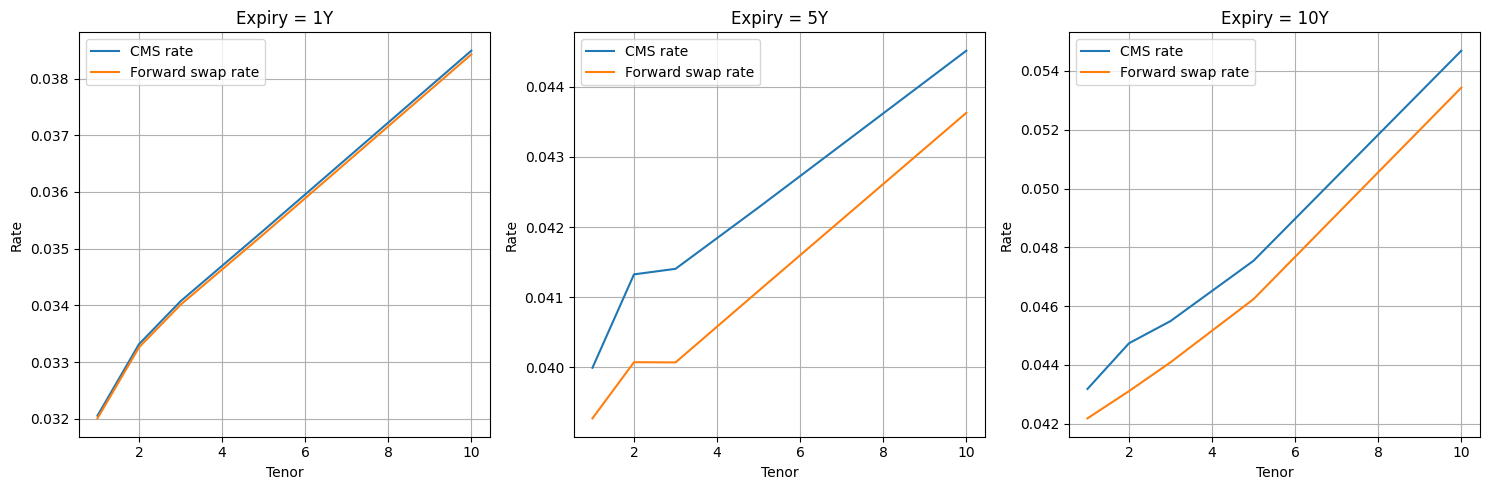

In [9]:
title_list = ['Expiry = 1Y', 'Expiry = 5Y', 'Expiry = 10Y']

fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

for i in range(3):
    axes[i].plot(N, summary["CMS rate"][i * 5 : (i + 1) * 5], label="CMS rate")
    axes[i].plot(N, summary["Forward swap rate"][i * 5 : (i + 1) * 5], label="Forward swap rate")
    axes[i].set_title(title_list[i])
    axes[i].set_ylabel("Rate")
    axes[i].set_xlabel("Tenor")
    axes[i].legend()
    axes[i].grid()

plt.tight_layout()  # Adjust spacing to prevent overlap
plt.show()

Discuss the effect of maturity and tenor on convexity correction (difference between forward swap rates and CMS rates).

**Response:** From the results above, we observe the following:

1. **Maturity effect**
   - **Short maturities (e.g., 1$y$)**: The convexity correction is minimal. For instance, the differences for $1y\times1y$, $1y\times2y$, and $1y\times3y$ are close to 0.000046 to 0.000062. This is because, for shorter maturities, the interest rate volatility and the time horizon over which convexity can accumulate are limited.
   - **Longer maturities (e.g., 10$y$)**: The convexity correction increases as the maturity grows. For example, for $10y\times10y$, the difference is 0.001257, which is significantly larger. This reflects the cumulative effect of convexity over time and the higher uncertainty in long-term interest rate movements.
<br></br>
2. **Tenor effect**: For a given maturity, convexity correction tends to increase with tenor. This is because:
   - Longer tenors imply more extended cash flow payments and larger potential deviations between the CMS and forward swap rates.
   - At $5y$ maturity: $5y\times1y$ (0.000721) has a smaller correction than $5y\times3y$ (0.001334).
   - At $10y$ maturity: $10y\times1y$ (0.001000) is smaller than $10y\times10y$ (0.001257).
<br></br>
3. **Key observations from data**
   - The convexity correction is smallest for shorter maturities and shorter tenors due to limited interest rate volatility and time horizon.
   - Convexity correction grows non-linearly with tenor and maturity due to the compounding effects of volatility and the integration terms in the CMS valuation formula.
<br></br>
4. **Link to results**
   - The SABR model accounts for skew and smile in volatility, amplifying the convexity correction for longer maturities and tenors.
   - The provided formulas for CMS rates incorporate integral terms dependent on strike price, volatility (via the SABR model), and IRR. These integrals increase with both maturity and tenor, leading to larger convexity corrections.
<br></br>
5. **Graphical insights**
   - The plots provided for $1y$, $5y$, and $10y$ expiries show a clear divergence between CMS rates and forward swap rates as tenor increases, reinforcing the mathematical findings.
   - This divergence is most pronounced for $10y$ expiry, reflecting the combined effect of long maturity and tenor.

In essence, convexity correction increases with both maturity and tenor due to higher volatility, longer time horizons, and the non-linear effects captured by the SABR model and IRR terms. Short maturities and tenors exhibit minimal corrections, while longer durations experience significant corrections, driven by cumulative volatility and the forward-looking nature of CMS rates.